In [341]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

In [342]:

    
#tenemos la matriz de pesos. Como tenemos la capa de input y una hidden, por eso tenemos dos pessos y dos bias
def retreive(model_dict):
    w1=model_dict['w1']
    b1=model_dict['b1']
    w2=model_dict['w2']
    b2=model_dict['b2']
    return w1,b1,w2,b2



    
def generate_w(k_classes, inpt_size,samples,hidden):
    """
    Use the random generator at Jax to generate a random generator to initialize the network
    """
    model={}
    key = random.PRNGKey(0)
    keys = random.split(key, 1)
    w1=jnp.array(random.normal(keys[0], (inpt_size,hidden )))
    w1=(w1-jnp.min(w1))/(jnp.max(w1)-jnp.min(w1))
    w2=jnp.array(random.normal(keys[0], (hidden,k_classes)))
    w2=(w2-jnp.min(w2))/(jnp.max(w2)-jnp.min(w2))
    b1=jnp.zeros((1,hidden))
    b2=np.zeros((1,k_classes))
    model['w1']=w1
    model['b1']=b1
    model['w2']=w2
    model['b2']=b2
    return model 

def forward(x,model_dict):
    w1,b1,w2,b2=retreive(model_dict)
    #input to hidden
    z1=jnp.transpose(x)@w1 +b1#size -> (hidden,samples)
    a1=jnp.tanh(z1)
    #print('este es el shape de a1',a1.shape,w2.shape)
    #hidden to output
    z2=a1@w2+b2 #size -> (classes,samples) ****
    #a2=jnp.tanh(z2) #RELU

    #and let's calculate the softmax applied to a2 because we'll need it in cross-entropy
    soft=jnp.exp(z2)/jnp.sum(jnp.exp(z2),axis=0) #size -> (classes, samples)

    return z1,a1,soft

def loss_function(y,soft):
    loss=jnp.mean(jnp.sum(-y*jnp.log(soft),axis=1)) #loss is a number
    return loss

def backpropagation(x,y,model_dict,samples,learning_rate):
    w1,b1,w2,b2=retreive(model_dict) 
    z1,a1,soft=forward(x,model_dict)
    
    #output to hidden
    #first, lets calculate error
    dz2=soft-y #size -> (classes, samples)
    
    #now we calculate the derivative
    dw2=(1/samples)*jnp.transpose(a1)@dz2 #size -> (classes, hidden)
    print('esta es la shape de dw2',dw2.shape)
    db2=(1/samples)*jnp.sum(dz2) #size -> (classes, 1)

    #hidden to input
    #first we calculate error
    print('esta es la shape de dz2',w2.shape,dz2.shape,jnp.power(jnp.tanh(z1),2).shape)
    #dz1=w2@jnp.transpose(dz2)@(1-jnp.power(jnp.tanh(z1),2))
    dz1=(w2@jnp.transpose(dz2))*jnp.transpose(1-jnp.power(jnp.tanh(z1),2)) #size -> (hidden,samples)
    print('shape de dz1 es',dz1.shape)
    dw1=(1/samples)*dz1@jnp.transpose(x)
    print('esta es la shape de dw1',dw1.shape)
    db1=(1/samples)*jnp.sum(dz1)
    #lambda_reg=0.01
    #dw2+=lambda_reg*np.sum(w2)
    #dw1+=lambda_reg*np.sum(w1)

    w1+=-learning_rate*jnp.transpose(dw1)
    b1+=-learning_rate*db1
    w2+=-learning_rate*dw2
    b2+=-learning_rate*db2
    
    #actualizamos el model
    model_dict={'w1':w1,'b1':b1,'w2':w2,'b2':b2}

    return model_dict
'''
def precision( y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP=0
        FP=0
        for i in range(len(y)):
            if(y_hat[i]>0 and y[i]>0):
                TP+=1
            if(y_hat[i]>0 and y[i]<0):
                FP+=1

        #TP = sum(y_hat[y>0]>0)
        #FP = sum(y_hat[y>0]<0)
        #precision_cpu = jax.jit(lambda x: x, device=self.cpus[0])(TP/(TP+FP))
        return (TP/(TP+FP))#float(precision_cpu)
        '''

def prediction(soft):
   
    
    return jnp.argmax(soft,axis=1)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return np.sum(predictions == Y) / 500

def accuracy( y, y_hat,k_clases,samples):
    """
    Precision
    args:
        y: Real Labels
        y_hat: estimated labels
    return TP/(TP+FP)
    """
    TP=0
    TN=0
    FP=0
    FN=0
    for j in range(k_clases):
        for i in range(samples):
            if(y_hat[i,j]>0 and y[i,j]>0) :
                TP+=1
            if(y_hat[i,j]<0 and y[i,j]<0):
                TN+=1
            if(y_hat[i,j]<0 and y[i,j]>0):
                FN+=1
            if(y_hat[i,j]>0 and y[i],j<0):
                FP+=1

    #TP = sum(y_hat[y>0]>0)
    #FP = sum(y_hat[y>0]<0)
    #accuracy_cpu = jax.jit(lambda x: x, device=self.cpus[0])((TP+TN)/(TP+FP+TN+FN))
    return ((TP+TN)/(TP+FP+TN+FN))#float(accuracy_cpu)
def modelo(x,y,samples,learning_rate,max_step,k_classes,inpt_size,hidden,y_0):
    model_dict=generate_w(k_classes, inpt_size,samples,hidden)
    for i in range(max_step):
        model_dict=backpropagation(x,y,model_dict,samples,learning_rate)
        soft=forward(x,model_dict)[2]
        loss=loss_function(y,soft)
        
        if i%10==0:
            
            y_hat=prediction(soft)
            ac=get_accuracy(y_hat,y_0)
            #print('La función de loss en la epoca {} es {:.3f}%, con un accuracy de {:.3f}%'
             #     .format(i,loss,ac))
            print(loss,i,ac)
        #if loss <=0.01:
         #   break
    return loss
            





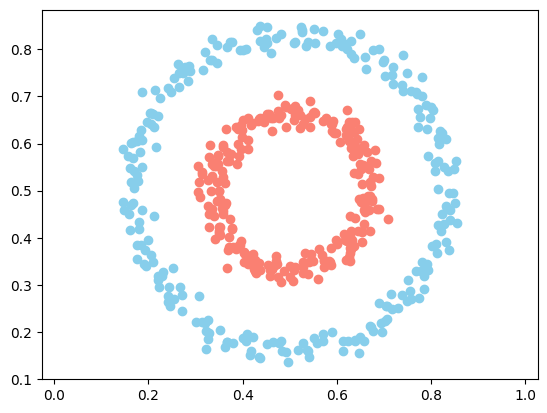

TypeError: dot_general requires contracting dimensions to have the same shape, got (500,) and (2,).

In [343]:
import pandas as pd
from sklearn.datasets import make_circles
#CREAR el data set  

n = 500   #este es el numero de set 

p = 2     #para las catracteristicas que vamos a conocer del set 

 
 

X, Y =make_circles(n_samples=n, factor=0.5,noise=0.05)  #es para hacer los circulos 

X=X/3+0.5 #para normalizar los datos 

Y=Y[:,np.newaxis] 

 
 
 
 

#  print(Y)    esto nos diría si un punto pertenece a un circulo u otro con 0 y 1 

plt.scatter(X[Y[:,0]==0,0],X[Y[:,0]==0,1], c="skyblue") 

plt.scatter(X[Y[:,0]==1,0],X[Y[:,0]==1,1],c="salmon") 

plt.axis("equal") 

plt.show() 

 
def one_hot_encode(df): 

    Hot_df=pd.DataFrame() 

    for i in range(df.shape[1]): 

        df_column=df.iloc[:,i] 

        Numero_clases_diferentes=df_column.unique().shape[0] 

        numero_elementos=df_column.shape[0] 

        clases_diferentes=df_column.unique().reshape((Numero_clases_diferentes,1)) 

        #convert type to string 

        #clases_diferentes=clases_diferentes.astype(str) 

            

        #clases_diferentes=np.array([['qgf'],['lkgf']]) 

        array_datos_clases=np.zeros(shape=(numero_elementos,Numero_clases_diferentes)) 

        iterador_clases=0 

        for titles in clases_diferentes: 

            for elemento in range(numero_elementos): 

                clase=df_column.iloc[elemento] 

                if clase==titles: 

                    array_datos_clases[elemento,iterador_clases]=1             

            iterador_clases +=1 

            

        df_HotEncoding=pd.DataFrame(array_datos_clases, 

                        columns=clases_diferentes.astype(str)) 

        Hot_df=pd.concat([Hot_df, df_HotEncoding], axis=1) 

    return Hot_df 

#aplicamos_one hot encode a Y  

Y_sinhot=Y 

df = pd.DataFrame(Y, columns=['clases']) 

Y=one_hot_encode(df) 

Y.shape 

#convertimos a numpy array 

Y=Y.to_numpy() 

samples=500

learning_rate=0.0018
max_step=10000
k_classes=2
inpt_size=2
hidden=4

neural_net=modelo(X,Y,samples,learning_rate,max_step,k_classes,inpt_size,hidden,Y_sinhot)



In [344]:
#before trying with MNIST lets try with something simpller
import sklearn.datasets
x,y=sklearn.datasets.make_moons(200,noise=0.15) #x are inputs and y are the expected labels
print(y)
x=jnp.transpose(x) #because we wrote the equations thinking that sizeX=(features,samples)
y_0=y

[0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0
 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0
 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1
 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1]


In [345]:
import pandas as pd
df=pd.DataFrame(y,columns=['y'])
renglones=df['y'].shape[0]
df_categorical=df[['y']]
columnas=df_categorical.shape[1]
one_hot=np.zeros(renglones)

col=0
df2=pd.DataFrame()
df3=pd.DataFrame()
df3.insert(0,'1',one_hot)
for k in range(0,columnas):
    name=df_categorical.columns[k]
    print(name)
    lista=[]
    lista=df_categorical[name].values.tolist()
    clases=df_categorical[name].unique() #un array de las distintas clases
    size_clases=len(clases)
    
    
    for i in range(size_clases):
        clase=clases[i]
        print(clase)

        for j in range(0,renglones):
            if lista[j]==clase:
                one_hot[j]=1  
        
        df2.insert(i,clase,one_hot)
        
        one_hot=np.zeros(renglones)
    df3=df3.join(df2)
    df2=pd.DataFrame()
del df3[df3.columns[0]]
y=df3.to_numpy()



y
0
1


In [346]:
#Now, we define the parameters for our neural network
samples=200

learning_rate=0.0018
max_step=10000
k_classes=2
inpt_size=2
hidden=3

neural_net=modelo(x,y,samples,learning_rate,max_step,k_classes,inpt_size,hidden,y_0)


esta es la shape de dw2 (3, 2)
esta es la shape de dz2 (3, 2) (200, 2) (200, 3)
shape de dz1 es (3, 200)
esta es la shape de dw1 (3, 2)
5.353712 0 0.228
esta es la shape de dw2 (3, 2)
esta es la shape de dz2 (3, 2) (200, 2) (200, 3)
shape de dz1 es (3, 200)
esta es la shape de dw1 (3, 2)
esta es la shape de dw2 (3, 2)
esta es la shape de dz2 (3, 2) (200, 2) (200, 3)
shape de dz1 es (3, 200)
esta es la shape de dw1 (3, 2)
esta es la shape de dw2 (3, 2)
esta es la shape de dz2 (3, 2) (200, 2) (200, 3)
shape de dz1 es (3, 200)
esta es la shape de dw1 (3, 2)
esta es la shape de dw2 (3, 2)
esta es la shape de dz2 (3, 2) (200, 2) (200, 3)
shape de dz1 es (3, 200)
esta es la shape de dw1 (3, 2)
esta es la shape de dw2 (3, 2)
esta es la shape de dz2 (3, 2) (200, 2) (200, 3)
shape de dz1 es (3, 200)
esta es la shape de dw1 (3, 2)
esta es la shape de dw2 (3, 2)
esta es la shape de dz2 (3, 2) (200, 2) (200, 3)
shape de dz1 es (3, 200)
esta es la shape de dw1 (3, 2)
esta es la shape de dw2 (3, 2)
